In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 10 #50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(1.5e3)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ALPHA = 1.0
BETA = 1.0
LAMBDA = 0.02

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/kernel_penalty_sphere/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def H(c, u, sigma=1.0):
    gram_mat = np.matmul(u, u.T)
    K = kappa(gram_mat, sigma=sigma)
    return 0.5 * np.matmul(c, np.matmul(K, c.T))

In [9]:
def kappa(s, sigma=1.0):
    return np.exp((s - 1) / sigma**2) - 1
    #return np.exp((s - 1) / sigma**2)

In [10]:
def projected_conic_update(c, u, sigma=1.0):
    signs = np.sign(c)    
    gram_mat = np.matmul(u, u.T)
    K = kappa(gram_mat, sigma=sigma)
    
    # mass updates
    c = (1 + 2 * ETA * signs * np.matmul(c, K)) * c
    
    # positions updates
    grad = (signs.T / sigma**2) * (np.matmul(c * K, u) - np.matmul(K * gram_mat, c.T) * u)
    u = u + ETA * grad
    
    # re-normalize particle positions on the sphere
    u = u / np.linalg.norm(u, axis=1, ord=2, keepdims=True)
    
    return c, u, grad

In [11]:
def train(sigma=1.0):
    #signs = np.sign(np.random.normal(size=(m, 1)))
    #signs = np.sign(np.random.normal(size=(1, m)))
    
    #signs = np.array([[1.0], 
    #                  #[1.0], 
    #                  [1.0]])#np.ones(shape=(m, 1))
    signs = np.array([[1.0, 1.0]])
    #                  #[1.0], 
    c = signs / m
    
    
    u = np.random.normal(size=(m, INPUT_DIM))
    u = u / np.linalg.norm(u, axis=1, ord=2, keepdims=True)
    alpha = 29*np.pi / 60
    #beta = 39*np.pi / 80
    u = np.array([[np.cos(alpha), np.sin(alpha)], 
                  #[0., 1.0],
                  [-np.cos(alpha), np.sin(alpha)]])
    
    us = [u]
    cs = [c]
    losses = [-H(c, u, sigma)[0, 0]]
    grads = []
    
    mass = np.sqrt(m * np.abs(c))
    as_ = [signs * mass]
    bs = [mass.T * u]
    
    for k in range(N_STEPS):
        c, u, grad = projected_conic_update(c, u, sigma)
        #a = a + ETA * grad_a_H(a, b, sigma)
        #b = b + ETA * grad_b_H(a, b, sigma)
        loss = -H(c, u, sigma)[0, 0]
        
        mass = np.sqrt(m * np.abs(c))
        
        cs.append(c)
        us.append(u)
        as_.append(signs * mass)
        bs.append(mass.T * u)
        losses.append(loss)
        grads.append(grad)
        
        
    return np.array(cs), np.array(us), np.array(as_), np.array(bs), np.array(losses), np.array(grads)

In [12]:
m = 2
INPUT_DIM = 2
ETA = 0.005
sigma = 0.08
N_STEPS = 1000

c, u, as_, bs, losses, grads = train(sigma=sigma)

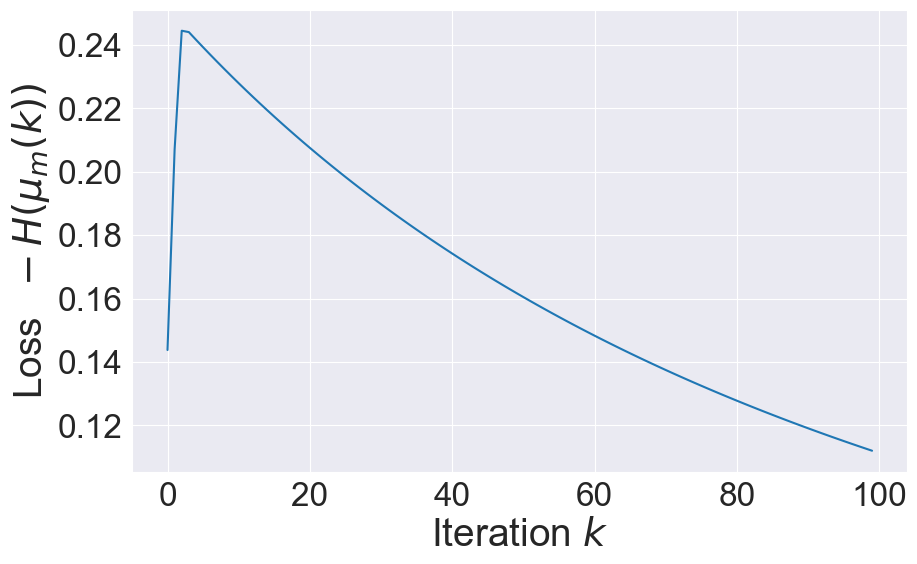

In [13]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')
n_iter = 100

plt.plot(np.arange(len(losses))[:n_iter], losses[:n_iter])

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Loss $\\ -H(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

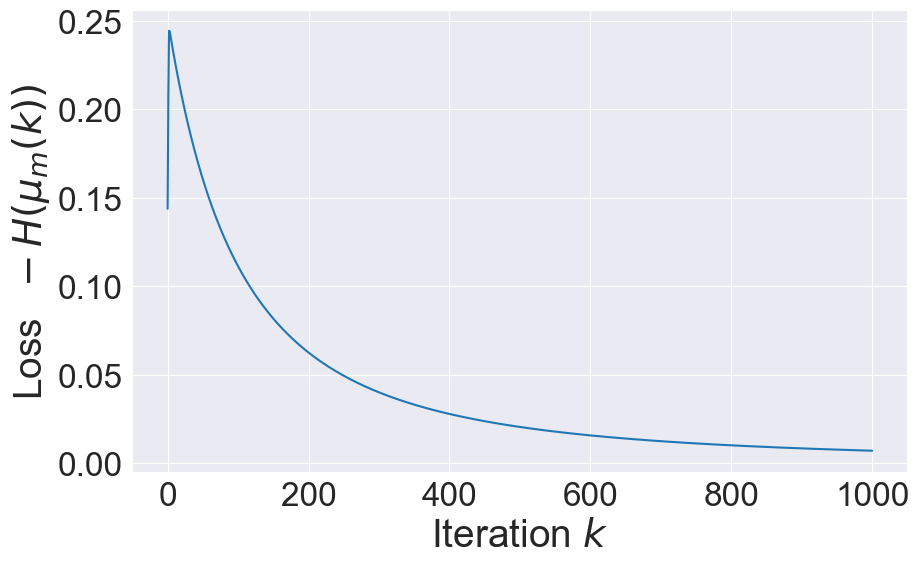

In [14]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(losses)), losses)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Loss $\\ -H(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

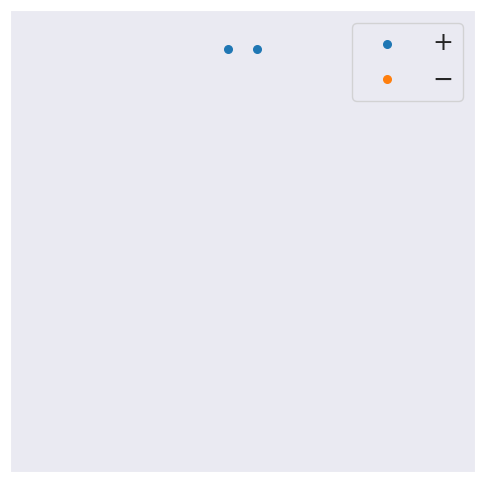

In [15]:
plt.figure(figsize=(6, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')
marker = 'o'

signs = c[0, 0, :]
pos = (signs > 0)
neg = (signs < 0)
u_pos = u[:, pos, :]
u_neg = u[:, neg, :]
u[:, neg, :]
k = 1

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

plt.scatter(u_pos[k, :, 0], u_pos[k, :, 1], marker=marker, s=30.0, label='$+$')
plt.scatter(u_neg[k, :, 0], u_neg[k, :, 1], marker=marker, s=30.0, label='$-$')
#plt.scatter(b_neg[k, :, 0], -0.5*np.ones(len(b_neg[k, :, 0])), marker=marker, s=30.0, label='$-$')

#plt.xlabel('Particle positions', fontsize=28)
#plt.ylabel('Pos / Neg', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks([])
plt.yticks([])
#plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

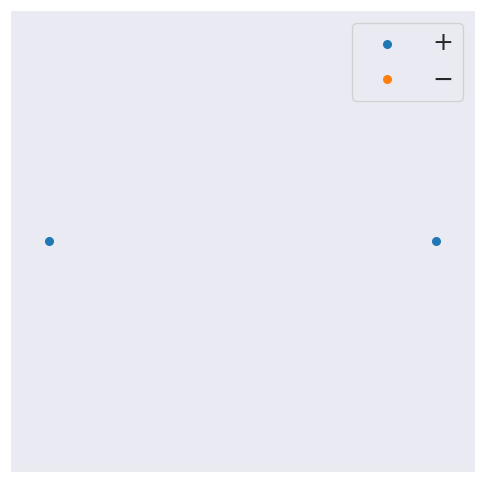

In [16]:
plt.figure(figsize=(6, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')
marker = 'o'

signs = c[0, 0, :]
pos = (signs > 0)
neg = (signs < 0)
u_pos = u[:, pos, :]
u_neg = u[:, neg, :]
u[:, neg, :]
k = 160

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

plt.scatter(u_pos[k, :, 0], u_pos[k, :, 1], marker=marker, s=30.0, label='$+$')
plt.scatter(u_neg[k, :, 0], u_neg[k, :, 1], marker=marker, s=30.0, label='$-$')
#plt.scatter(b_neg[k, :, 0], -0.5*np.ones(len(b_neg[k, :, 0])), marker=marker, s=30.0, label='$-$')

#plt.xlabel('Particle positions', fontsize=28)
#plt.ylabel('Pos / Neg', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks([])
plt.yticks([])
#plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [ ]:
## marker = 'o'
signs = a[0, :, 0]
pos = (signs > 0)
neg = (signs < 0)
b_pos = b[:, pos, :]
b_neg = b[:, neg, :]

marker = 'o'
for k in range(len(b)):
    plt.figure(figsize=(6, 6))
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)

    plt.scatter(b_pos[k, :, 0], b_pos[k, :, 1], marker=marker, s=30.0, label='$+$')
    plt.scatter(b_neg[k, :, 0], b_neg[k, :, 1], marker=marker, s=30.0, label='$-$')

    plt.xticks([])
    plt.yticks([])
    plt.legend(fontsize=18)

    plt.savefig(os.path.join(FIGURES_DIR, 'attraction-repulsion_{}.png'.format(k)), bbox_inches='tight')
    plt.close()

In [27]:
k = 0
c[k, :, 0]

array([ 0.03333333, -0.03333333,  0.03333333,  0.03333333, -0.03333333,
       -0.03333333,  0.03333333,  0.03333333, -0.03333333,  0.03333333,
       -0.03333333, -0.03333333,  0.03333333, -0.03333333, -0.03333333,
       -0.03333333, -0.03333333,  0.03333333, -0.03333333, -0.03333333,
        0.03333333, -0.03333333,  0.03333333, -0.03333333, -0.03333333,
        0.03333333, -0.03333333,  0.03333333, -0.03333333, -0.03333333])

In [45]:
k = 387
c[k, :, 0]

array([ 6.09361470e-02, -1.77311485e+03,  6.21784422e-02,  1.38065279e+01,
       -8.16212655e-02, -3.39882976e+10,  6.52264204e-01,  7.62792618e+04,
       -1.52646557e+03,  1.38272588e+01, -6.91841453e-02, -3.78261507e+12,
        3.35612910e-01, -2.69078359e+09, -6.48194651e-02, -2.68931888e+09,
       -3.06814846e-02,  3.34181296e-01, -2.65681008e+03, -3.07545640e+00,
        6.36277500e-02, -2.65688546e+03, -3.56678506e-01, -3.07781565e+00,
       -1.76885495e+03,  6.19649025e-02, -7.14728820e-02,  7.65638556e+04,
       -3.39882962e+10, -3.78241820e+12])

In [267]:
def f(s, sigma=0.08):
    return np.exp(s/(sigma**2)) * (1 - s**2)

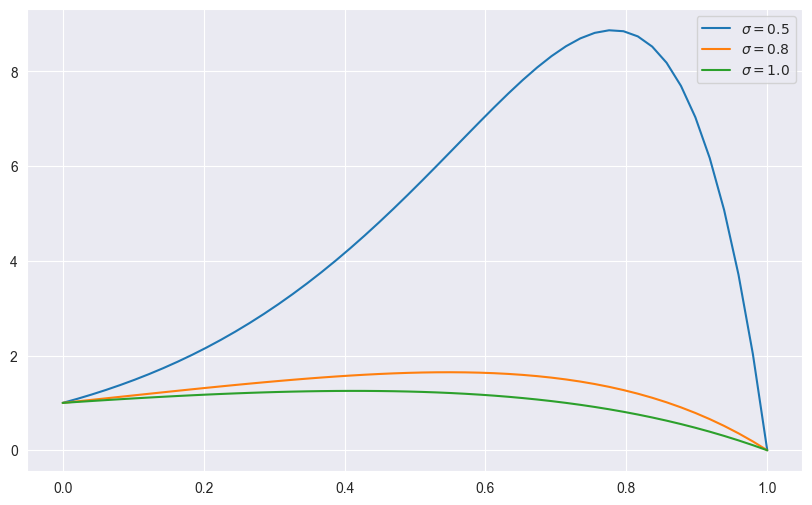

In [275]:
plt.figure(figsize=(10, 6))

xs = np.linspace(start=0., stop=1.0, num=50, endpoint=True)
#sigmas = [0.001, 0.005, 0.01, 0.05, 0.08, 1.0]
sigmas = [0.5, 0.8, 1.0]
for sigma in sigmas:
    ys = f(xs, sigma)
    plt.plot(xs, ys, label='$\\sigma={}$'.format(sigma))

plt.legend()
plt.show()